In [ ]:
# Step 1: Install Kaggle API
!pip install -q kaggle

# Step 2: Upload Kaggle API Key
from google.colab import files
files.upload()  # Manually upload kaggle.json

# Step 3: Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

# Step 4: Download the dataset from Kaggle
!kaggle datasets download -d kamal01/top-agriculture-crop-disease

# Step 5: Unzip the dataset
!unzip -q top-agriculture-crop-disease.zip -d /content/dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kamal01/top-agriculture-crop-disease
License(s): CC0-1.0
100% 4.32G/4.33G [00:52<00:00, 113MB/s]
100% 4.33G/4.33G [00:52<00:00, 89.2MB/s]


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten,Dense,MaxPooling2D,Conv2D,Dropout, BatchNormalization

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load Pretrained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze base layers

# Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replace Flatten
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(17, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


<ipython-input-3-d73eb0d1f483>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │           2,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,424,145 (9.25 MB)

 Trainable params: 166,161 (649.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

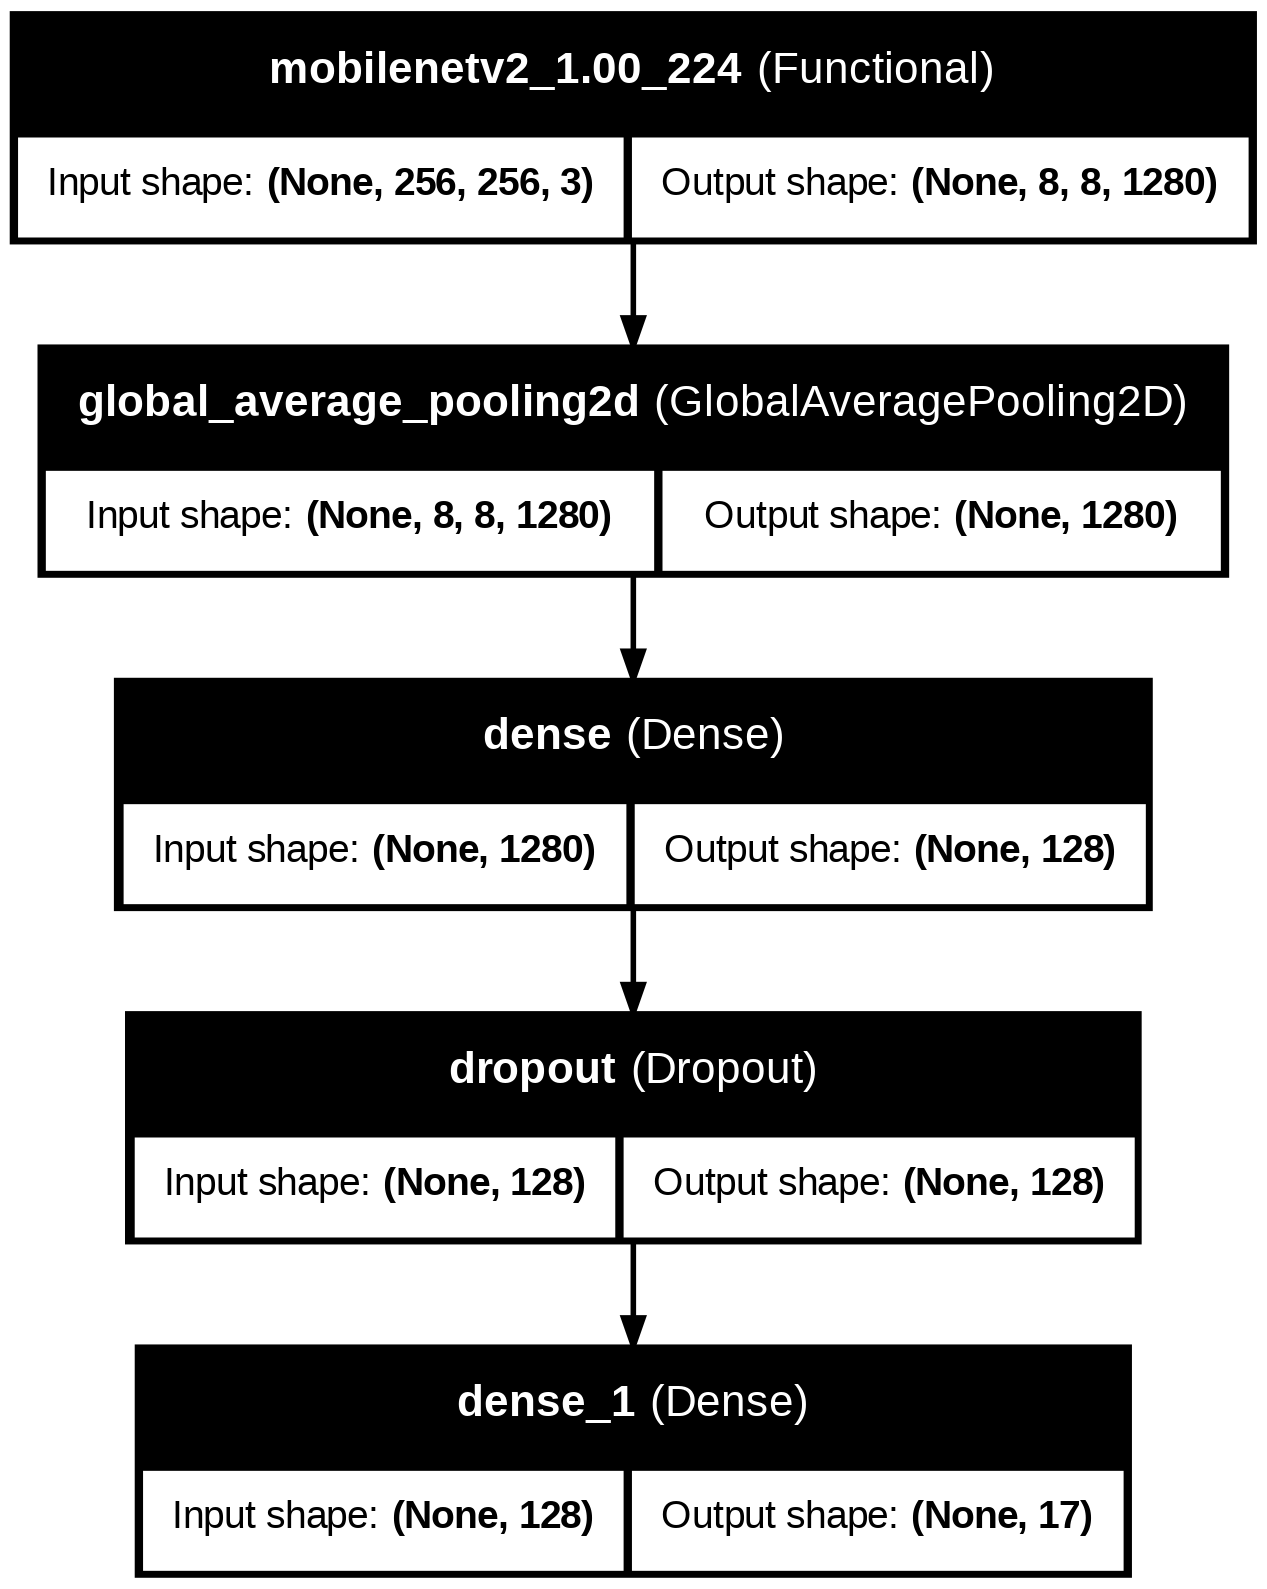

In [ ]:
plot_model(model,show_layer_names=True,show_shapes=True)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
dataset_path ='/content/dataset/Crop Diseases'

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


train_set = datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_set = datagen.flow_from_directory(
    dataset_path, # same directory as training data
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation')
icd = {i: j for j, i in train_set.class_indices.items()}
print(icd)

Found 10664 images belonging to 17 classes.
Found 2660 images belonging to 17 classes.
{0: 'Corn___Common_Rust', 1: 'Corn___Gray_Leaf_Spot', 2: 'Corn___Healthy', 3: 'Corn___Northern_Leaf_Blight', 4: 'Potato___Early_Blight', 5: 'Potato___Healthy', 6: 'Potato___Late_Blight', 7: 'Rice___Brown_Spot', 8: 'Rice___Healthy', 9: 'Rice___Leaf_Blast', 10: 'Rice___Neck_Blast', 11: 'Sugarcane_Bacterial Blight', 12: 'Sugarcane_Healthy', 13: 'Sugarcane_Red Rot', 14: 'Wheat___Brown_Rust', 15: 'Wheat___Healthy', 16: 'Wheat___Yellow_Rust'}


In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=50,  # More epochs for better learning
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.6910 - loss: 0.9267 - val_accuracy: 0.8519 - val_loss: 0.3827
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8674 - loss: 0.3463 - val_accuracy: 0.8602 - val_loss: 0.3290
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 322s 961ms/step - accuracy: 0.8778 - loss: 0.3033 - val_accuracy: 0.8553 - val_loss: 0.3634
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 324s 971ms/step - accuracy: 0.8772 - loss: 0.2921 - val_accuracy: 0.8650 - val_loss: 0.3460
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 325s 971ms/step - accuracy: 0.8935 - loss: 0.2656 - val_accuracy: 0.8632 - val_loss: 0.3444
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.8977 - loss: 0.2649 - val_accuracy: 0.8763 - val_loss: 0.3531
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.8998 - loss: 0.2452 - val_accuracy: 0.8744 - val_loss: 0.3467


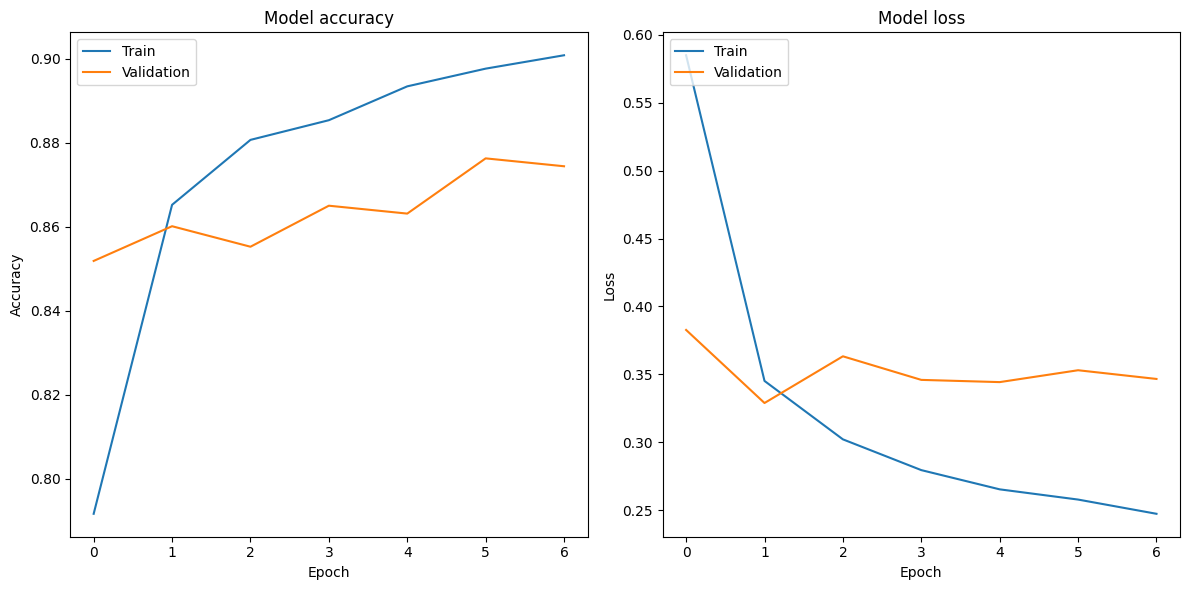

In [ ]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Reverse the class indices dictionary
icd = {i: j for j, i in train_set.class_indices.items()}

def predict_image(location, model):
    # Load and preprocess image
    img = load_img(location, target_size=(256, 256))  # Ensure same size
    img = img_to_array(img) / 255.0  # Normalize (rescale=1./255)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Print result
    print(f"Predicted Class: {icd[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Pridicted Class Corn___Northern_Leaf_Blight


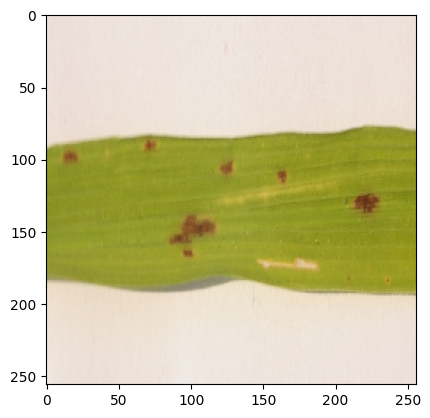

In [ ]:
test_img='/content/DSC_0303.jpg'
pic=load_img(test_img,target_size=(256,256,3))
plt.imshow(pic)
output(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Pridicted Class Rice___Neck_Blast


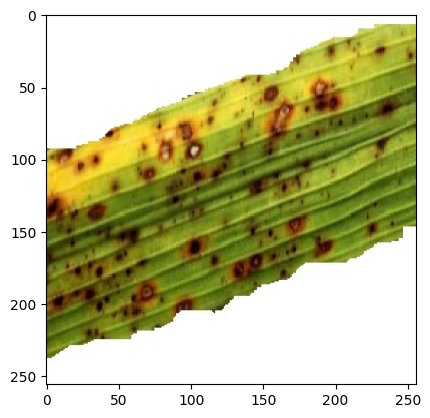

In [ ]:
test_img='/content/DSC_0101.jpg'
pic=load_img(test_img,target_size=(256,256,3))
plt.imshow(pic)
output(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Pridicted Class Wheat___Brown_Rust


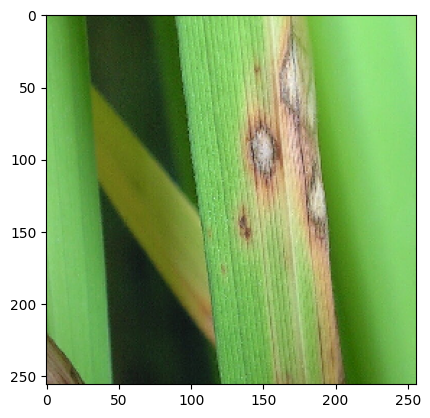

In [ ]:
test_img='/content/rc.jpg'
pic=load_img(test_img,target_size=(256,256,3))
plt.imshow(pic)
output(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Pridicted Class Rice___Brown_Spot


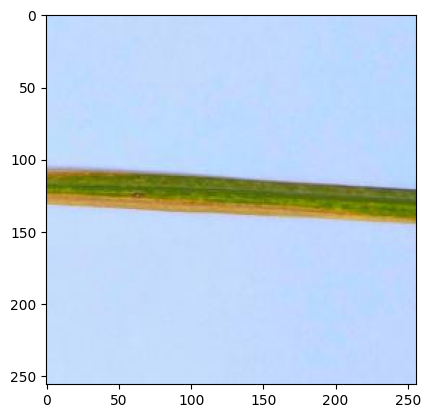

In [ ]:
test_img='/content/IMG_20190419_095031.jpg'
pic=load_img(test_img,target_size=(256,256,3))
plt.imshow(pic)
output(test_img)

In [ ]:
# Save the model in the new Keras format
model.save("plant_disease_model.keras")

